# Grad-CAM

可视化模型对图像的关注区域

![image-grad](./grad.png)

<!-- 1. 给定一个图像(属于某个类别),作为输入
2. 通过 `CNN` 的前向传播,得到图像对于某个类别的原始分数
3. 对于除了输入图像的类别其余类别的梯度设置为`0`
4. 将梯度用于反向传播到感兴趣的矫正卷积特征从 -->

- 网络进行正向传播,得到特征层`A`(指最后一个卷积的输出)和网络预测值`y`(softmax函数激活之前),想查看网络对于类别`Tiger cat`的感兴趣区域,假设输出的预测值为:$y^{a}$
- 将$y^{a}$进行反向传播,得到特征层的`A`的梯度信息`A'`,计算针对特征层`A`的每个重要程度
- 加权求和,最后经过`ReLU`得到`Grad-CAM`

通过使用最后一层卷积层的梯度信息来为每个神经元分配重要的值,用于特定感兴趣决策

越往后的特征层抽象程度越高,语义信息越丰富,所以使用特征层的最后一个卷积输出



1. 先计算类别

获取神经元的重要性权重
$$\alpha ^{c}_{k}=\frac{1}{Z}\sum_{i}^{}\sum_{j}\partial \frac{y^{c}}{\partial A^{k}_{ij}} \\\frac{1}{Z}\sum_{i}^{}\sum_{j}=Global Average Pooling$$ 


对于$C$类别的梯度类激活图

$$L^{c}_{Grad-CAM}=ReLU(\sum_{k}\alpha ^{c}_{k}A^{k})$$

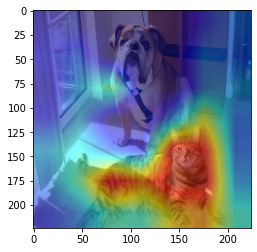

In [2]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models
from torchvision import transforms
from utils import GradCAM, show_cam_on_image, center_crop_img
import torchvision

model = models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
target_layers = [model.features[-1]]  # 传入模块的最后一层

data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# load image
img_path = "cat.png"

assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
img = Image.open(img_path).convert('RGB')
img = np.array(img, dtype=np.uint8)
# img = center_crop_img(img, 224)
# [C, H, W]
img_tensor = data_transform(img)
# expand batch dimension
# [C, H, W] -> [N, C, H, W]
input_tensor = torch.unsqueeze(img_tensor, dim=0)
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
target_category = 281  # tabby, tabby cat(从0开始所以 -1)
# target_category = 254  # pug, pug-dog
grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img.astype(dtype=np.float32) / 255.,
                                  grayscale_cam,
                                  use_rgb=True)
visualization
plt.imshow(visualization)
plt.show()

# 代码阅读

#### 钩子函数

- hook作用:获取变量的中间结果,不使用hook函数Pytorch会自动舍弃图计算的中间结果,在hook函数使用之后要及时删除
- hook两种类别
    - Tensor 级别
        register_hook(hook):为Tensor类型的数据注册一个 backward hook,来获取变量的梯度


In [11]:
import torch
from PIL import Image
import numpy as np

In [12]:
v = torch.tensor([0., 0., 0.], requires_grad=True)
h = v.register_hook(lambda grad: grad * 2)  # double the gradient
v.backward(torch.tensor([1., 2., 3.]))
print(v.grad)
h.remove() # 移除钩子函数

tensor([2., 4., 6.])


- nn.Module 级别
    register_forward/backward_hook(hook):前向传播和反向传播

In [13]:
# 利用钩子函数提取中间层的数据
# features = torch.Tensor() 
# input = torch.ones(1,3,224,224)
# def hook(model,input,output):
#     # 复制中间层数据
#     features.copy_(output.data)
# handel = model.features[20].register_forward_hook(hook)

# model(input.cuda())

# 用完删除
# handel.remove()

In [14]:
# hasattr 对象中包含对应的属性
class test:
    a=100
    b=1
a = test
if hasattr(a,'a'):
    print('success')
else:
    print('None')

success


`np.array` 的图像`shape`格式为`[Height,Width,Channel]`

In [15]:
Img = Image.open('../../Project/image/car.png').convert('RGB')
img_np = np.array(img)
print(img_np.shape)

(224, 224, 3)


In [3]:
# 通过resnet网络可视化
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models
from torchvision import transforms
from utils import GradCAM, show_cam_on_image, center_crop_img
from restnet import resnet50
import torchvision

def draw_image(row,col,img_list,title_list):
    for i in range(col*row):
        plt.subplot(row,col,i+1)
        plt.imshow(img_list[i]/255)
        plt.title(title_list[i])
        plt.xticks([]),plt.yticks([])

model=resnet50(pretrained=True,pth_path="/data0/yy_data/FGVC/MMAL-Net/Pretrained/resnet50-19c8e357.pth")
target_layers = [model.layer1,model.layer2,model.layer3,model.layer4]

# input_tensor = torch.unsqueeze(img_tensor, dim=0)
# cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
# target_category = 281  # tabby, tabby cat(从0开始所以 -1)
# grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(img.astype(dtype=np.float32) / 255.,
#                                   grayscale_cam,
#                                   use_rgb=True)
def cam_get(path):
    data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    # load image
    root = "/data0/yy_data/Dataset/CUB_1/test/"
    img_path = root+path
    # 判断图片是否存在
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path).convert('RGB')
    img = np.array(img, dtype=np.uint8)
    # [C, H, W]
    img_tensor = data_transform(img)
    # expand batch dimension
    # [C, H, W] -> [N, C, H, W]
    input_tensor = torch.unsqueeze(img_tensor, dim=0)
    target_category = 5  # 代表根据不同的类别对应的梯度
    img_cam = []
    img_cam.append(img)
    for i in target_layers:
        
        cam = GradCAM(model=model, target_layers=i, use_cuda=True)
   
        grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

        grayscale_cam = grayscale_cam[0, :]

        visualization = show_cam_on_image(img.astype(dtype=np.float32) / 255.,
                                      grayscale_cam,
                                      use_rgb=True)
        img_cam.append(visualization)
    return img_cam
   
cam_img =cam_get("004.Groove_billed_Ani/Groove_Billed_Ani_0077_1724.jpg")
img_title=['origion image ','layer 1','layer 2','layer 3','layer 4']

        
draw_image(1,5,cam_img,img_title)


resnt


TypeError: tuple indices must be integers or slices, not tuple

In [5]:
from torch import nn
from restnet import resnet50

class SE(nn.Module):
    def __init__(self,channel,r=16) -> None:
        super(SE,self).__init__()        
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(
            nn.Conv2d(channel,channel//r,1,bias=False),
            nn.ReLU(),
            nn.Conv2d(channel//r,channel,1,bias=False),
            nn.Sigmoid()
        )
    def forward(self,x):
        y = self.avg_pool(x)
        print("y shape:",y.shape)
        y = self.fc(x)
        return x*y

class MainNet(nn.Module):
    def __init__(self) -> None:
        super(MainNet,self).__init__()
        self.model = resnet50(pretrained=True,pth_path="/data0/yy_data/FGVC/MMAL-Net/Pretrained/resnet50-19c8e357.pth")
        self.se = SE(1024)
    def forward(self,x):
        
        layer_3,x =  self.model(x)
       
        # tep = x
        x = self.se(layer_3)
        # print(self.se(x)==x)
        return x,layer_3
x = torch.ones((1,3,448,448))
model = MainNet()
out = model(x)
# print(model)
# target_layers = [model]
# img_title=['origion image ','layer se']
# cam_image =cam_get("004.Groove_billed_Ani/Groove_Billed_Ani_0077_1724.jpg")

# cam_get("004.Groove_billed_Ani/Groove_Billed_Ani_0077_1724.jpg",)

resnt
y shape: torch.Size([1, 1024, 1, 1])


In [15]:
# model = resnet50(pretrained=True,pth_path="/data0/yy_data/FGVC/MMAL-Net/Pretrained/resnet50-19c8e357.pth")
# SE
import numpy as np
class SE(nn.Module):
    def __init__(self,channel,r=16) -> None:
        super(SE,self).__init__()        
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(
            nn.Conv2d(channel,channel//r,1,bias=False),
            nn.ReLU(),
            nn.Conv2d(channel//r,channel,1,bias=False),
            nn.Sigmoid()
        )
    def forward(self,x):
        y = self.avg_pool(x)
        y = self.fc(x)
        return x*y

class MainNet(nn.Module):
   
    def __init__(self) -> None:
        super(MainNet,self).__init__()
        self.se = SE(1024)
        self.model = resnet50(pretrained=True,pth_path="/data0/yy_data/FGVC/MMAL-Net/Pretrained/resnet50-19c8e357.pth")
    def forward(self,x):
        x =  self.model(x)
        print('x shape',x.shape)
         
        # x_ = self.se(x)
        # print('插值',x-x_)
        # print('se shape',x.shape)
        return x

model = MainNet()

############################
####    modules
# for idx,i in enumerate(model.modules()):
#     print(idx,'->',i)
####    named_buffers
# for name,buffer in model.named_buffers():
#     print(name)
#     print(buffer)
#     break

####    named_childeren()
# for name ,child in model.named_children():
#     print(name,'======\n',child)
####    named_modules()
# for idx ,m in enumerate(model.named_modules()):
#     print(idx,'======\n',m)


0 ======
 ('', MainNet(
  (se): SE(
    (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (fc): Sequential(
      (0): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): ReLU()
      (2): Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): Sigmoid()
    )
  )
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum

### 特征图可视化

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
 
 
# 导入数据
def get_image_info(image_dir):
    # 以RGB格式打开图像
    # Pytorch DataLoader就是使用PIL所读取的图像格式
    # 建议就用这种方法读取图像，当读入灰度图像时convert('')
    image_info = Image.open(image_dir).convert('RGB')
    # 数据预处理方法
    image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image_info = image_transform(image_info)
    image_info = image_info.unsqueeze(0)
    return image_info
 
# 获取第k层的特征图
def get_k_layer_feature_map(feature_extractor, k, x):
    with torch.no_grad():
        for index,layer in enumerate(feature_extractor):
            x = layer(x)
            if k == index:
                return x
 
#  可视化特征图
def show_feature_map(feature_map):
    feature_map = feature_map.squeeze(0)
    feature_map = feature_map.cpu().numpy()
    feature_map_num = feature_map.shape[0]
    row_num = np.ceil(np.sqrt(feature_map_num))
    plt.figure()
    for index in range(1, feature_map_num+1):
        plt.subplot(row_num, row_num, index)
        plt.imshow(feature_map[index-1], cmap='gray')
        plt.axis('off')
        scipy.misc.imsave(str(index)+".png", feature_map[index-1])
    plt.show()
 
 
def feature_map_show(img,layer,use_gpu,model):
    img_info = get_image_info(img)
    if use_gpu:
        model = model.cuda()
        img_info = img_info.cuda()
    feature_extractor = model.
            
     

## 针对分类结果混淆矩阵的可视化




In [55]:
 ## 混淆矩阵：评判模型结果的一种指标(评判分类器模型)
import os
import json

import torch
from torchvision import transforms, datasets
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from prettytable import PrettyTable



class ConfusionMatrix():
    r'''混合矩阵对分类结果可视化
    '''
    def __init__(self,num_class:int,labels:int):
        # 初始化混淆矩阵
        self.matrix = np.zeros((num_class,num_class))
        self.num_class = num_class
        self.label = labels                       
    def update(self,preds,labels):
        for p,t in zip(preds,labels):
                self.matrix[p,t] +=1
    def summary(self):
    #各项数据的总结
        sum_TP =  0
        for i in range(self.num_class):
            # 分类正确
            sum_TP +=self.matrix[i,i]
        acc = sum_TP /np.sum(self.matrix)
        print('the model accuracy :',acc)
        # 精度，召回，精确
        table = PrettyTable()
        # 各个指标
        table.field_names = ["","Precision","Recall","Specificity"]
        for i in range(self.num_class):
            # true positive
            TP = self.matrix[i,i]
            # false positive
            FP = np.sum(self.matrix[i,:])-TP
            # false negative
            FN = np.sum(self.matrix[:,i])-TP
            # true negative
            TN = np.sum(self.matrix)-TP-FP-FN
            Precision = round(TP / (TP + FP), 3) if TP + FP != 0 else 0.
            Recall = round(TP / (TP + FN), 3) if TP + FN != 0 else 0.
            Specificity = round(TN / (TN + FP), 3) if TN + FP != 0 else 0.
            table.add_row([self.labels[i], Precision, Recall, Specificity])
        print(table)
        
    def plot(self):
        matrix = self.matrix
        print(matrix)
        plt.imshow(matrix)
        
        # 设置X轴坐标(标签旋转角度)
        plt.xticks(range(self.num_class),self.label,rotation=45)
        # 设置Y轴坐标
        plt.yticks(range(self.num_class),self.label)
        plt.colorbar()
        plt.xlabel('True Labels')
        plt.ylabel('Predicted Labels')
        plt.title('Confusion matrix')
        
        # 在图中标注数量/概率信息
        thresh = matrix.max()/2
        for x  in range(self.num_class):
            for y in range(self.num_class):
                info = int(matrix[y, x])
                plt.text(x, y, info,
                         verticalalignment='center',
                         horizontalalignment='center',
                         color="white" if info > thresh else "black")
        plt.tight_layout()
        plt.show()

 

ConfusionMatrix()

def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # 使用类别标签
    label = 
    confusion = ConfusionMatrix(num_class=200,label)
    
    net.eval()
    with torch.no_grad():
        for test_data in tqdm(testdata_loader):
            test_images ,test_label = test_data
            outputs = torch.softmax(net(test_images.to(device)),dim=1)
            outputs = torch.argmax(outputs,dim=1)
            confusion.update(outputs.to('cpu').numpy(),test_label.to('cpu').numpy())
    confusion.plot()
    confusion.summary()
            

SyntaxError: invalid syntax (4187260486.py, line 7)

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])